# Piloting headless browsers with Python

<p style="margin-top:-1.25em; margin-bottom: 1.25em;"><em>Companion notebook to Joe Taylor's presentation on April 7<sup>th</sup>, 2021</em></p>

If you're like me, then the title of this talk may bring to mind all sorts of interesting things, like headless horsemen or snakes on a plane. Those they are not, but by the end of our conversation I hope to have demystified headless browsers enough to show that, even though they are merely tools for some down to earth data gathering and web testing techniques, that's okay, because piloting headless browsers can be quite interesting anyhow! I'll cover what headless browsers are, why they're useful, and why I chose to use python to pilot them. I'll also preview their capabilities with a demo of common use cases.


Required imports:

In [1]:
import playwright            # This is our headless browser library and the star of the show.
                             # It gives us new ways to automate, test, or extract information from web pages.

import requests              # This library, together with a DOM parsing library like beautiful soup (below),
                             # or in rare cases regular expressions, is what would traditionally be used to extract
                             # information from HTML-based web resources.
    
import bs4                   # beautifulsoup - this is a good way to parse HTML that may or may not
                             # be structurally valid. It can be used with playwright but it is not usually necessary
                             # since the browsers that playwright controls will have already parsed the
                             # HTML for you.

from PIL import Image        # We mainly use this to view images in our Jupyter notebook,
                             # but we could also use it to process, transform, or draw on them

import ipywidgets as widgets # widgets.Image is another way to view images in notebooks. It's advantage over pillow's Image
                             # class is that is its output can be reactively updated for a live rendering of changing imagery.
                             # Its disadvantage is that an image widget is not the expected format for other image processing libraries
                             # so the image it contains cannot be passed around to other libraries as easily.
            
from IPython.display import display # We're importing this for when jupyter's implicit rendering is not
                                    # enough. It allows us to display many outputs in one cell.
                             
import re                    # A (or, for pythonistas, "the") regular expression library.
                             # Useful, and recommended for a variety of text processing
                             # and pattern matching problems, but in this case we're using it to
                             # demonstrate how NOT to extract information from structured HTML
    
from io import BytesIO       # This is a convenience wrapper that allows us to open bytes
                             # that are loaded into memory as though they were files. We use
                             # it with the return value of the screenshot() method.
    
import asyncio as aio        # This library gives us some nice abstractions to help us write code
                             # that does more than one thing at once

Optional:

In [2]:
import pytesseract           # This allows us to extract text content from images via OCR.
                             # It's not necessary to use OCR to extract text content, but it may be
                             # useful if for example you are concerned only with the textual content that
                             # is truly visible, or with words that are visible above the fold.

## Following along

This notebook is designed to work with a modern python, preferably version 3.7+. If the import statements above work without issues, then you should be good to go. If not, please prepare an environment with the following dependencies installed via pip:

 - requests
 - bs4
 - pillow
 - ipywidgets
 - ipython
 - pytesseract *- optional, to demonstrate OCR of screenshots*
 - playwright *- additional setup instructions follow* 
 
Playwright also depends on nodejs. Instructions for installing node are not included here; please refer to the appropriate documentation for your operating system.
 
To install the listed dependencies in a virtual environment and follow along (assuming node has already been installed), you can open your shell of choice and issue commands resembling the following:

    python3 -mvenv headlessbrowserstalk
    source headlessbrowserstalk/bin/activate
    pip install requests playwright bs4 pillow pytesseract ipywidgets ipython jupyterlab
    playwright install
    jupyter lab

## Why Python?

Headless browsers are usually controlled using JavaScript, because that's the language most headless browser piloting libraries are written in. Even though the headless browser libraries tend to be written for JavaScript first, and enjoy the best native support in that language, I actually prefer to use the python bindings, especially for problems that are still in the explorative stage. There are many possible justifications I could point to in support of this preference, not least of which is ready access to Python's vibrant machine learning ecosystem, but the reason I prefer to use the Python-based libraries really comes down to one thing: superior integration with Jupyter notebooks. Jupyter notebooks are one of the best tools available for explorative programming, and Jupyter notebooks and headless browsers work together wonderfully!

## What are headless browsers, and what problems do they solve?

In a previous talk, I said that headless browsers are like regular browsers, only you can't see what they're doing. That's not true at all. Headless browsers may well be defined by their lack of a regular user interface, but that doesn't mean you can't observe what they're doing. In fact, headless browsers can be observed in many different ways, and headless browsers' observability, especially with visual methods, is one of their key differentiators from other historical options in the web testing and automation problem space. Using an API to control a web browser may even reveal things to you that wouldn't be apparent without a suite of programmatic helpers to augment your insight.

To demonstrate where headless browsers are most useful, let's start with a problem that can be solved using conventional methods, then compare and contrast with a headless browser based approach.

## Testing to ensure a website is loading correctly using a traditional approach


Let's say we wanted to check to ensure a web page is live and returning the correct title. Using the requests library, we can easily test to see if it's loading and reporting a status of 200/OK.

In [3]:
import requests
response = requests.get("https://www.healthlinkbc.ca")
response_html = response.content.decode()
assert response.status_code == 200

Using regular expressions, we might extract the title using something like the following:

In [4]:
re.search(r"<title>[^>]+</title>", response_html)

<re.Match object; span=(282, 345), match='<title>HealthLink BC - 24/7 Health Advice You Can>

This becomes problematic, however, when dealing with nested structures. It may not be obvious from the example above, but this approach would not work reliably if we were matching the contents of a &lt;div&gt; tag surrounding another &lt;div&gt; tag. Therefore, using regular expressions to extract content from HTML is discouraged, and it's generally recommend to use a parser like Beautiful Soup instead.

In [5]:
bs4.BeautifulSoup(response_html).select("title")

[<title>HealthLink BC - 24/7 Health Advice You Can Trust</title>]

Most of the time, something like the above will suffice, but there will also be times when your code needs to take a more holistic view of a website, and also consider the effects of JavaScript dynamically changing the <acronym title="Document Object Model">DOM</acronym> tree, or take into account visual information. That's where headless browsers come in.

## Using headless browsers

There are many headless browser libraries. The main ones (the most popular and widely used) include:

 - Selenium
 - Puppeteer
 - Playwright
 
Playwright is the newest of the three, and also, in my opinion, the best of the bunch. It enjoys dedicated support from its team of maintainers at Microsoft, and its python bindings (many of which are automatically generated)  track closely to the latest developments in its upstream nodejs-based project. Both selenium and puppeteer also have python bindings, but selenium's focus is cross-browser testing using a common API. This common denominator based approach makes it less useful for general automation. As for puppeteer, its python-based counterpart, pyppeteer, is not frequently updated and has fallen behind with the JavaScript library, and many of puppeteer's original maintainers have been hired by Microsoft to work on playwright.

We will focus on playwright and its API. It will be familiar to people who have prior experience with puppeteer.

### Opening and closing a browser

We're going to use the asynchronous API instead of the synchronous one, because that API makes it easier to do more than one thing at once and is a more natural match for the event-driven protocol at playwright's foundation (Chrome DevTools Protocol).

In [6]:
from playwright.async_api import async_playwright
p = await async_playwright().start()

Playwright bundles chromium, webkit, and firefox:

In [7]:
[prop for prop in dir(p) if isinstance(getattr(p, prop), playwright.async_api._generated.BrowserType)]

['chromium', 'firefox', 'webkit']

We'll use chromium for this talk. First, here's how to open a new browser instance which is NOT headless. To use a headless browser instead, omit the `headless=False` parameter.

In [8]:
browser = await p.chromium.launch(headless=False)

Now let's close it:

In [9]:
await browser.close()

### Opening one tab or several

There are just a few simple commands to open a tab in a browser instance.

In [10]:
browser = await p.chromium.launch(headless=False)

In [11]:
pg = await browser.new_page()

Every page is associated with a context. One is created automatically for you when you call the `new_page` function of the browser object.

In [12]:
assert len(browser.contexts) == 1

In [13]:
assert browser.contexts[0].pages[0] == pg

In [14]:
assert pg.context == browser.contexts[0]

One problem with creating a new context using this approach is that you can't subsequently add new pages to it, and thus, session information can't be shared across tabs.

In [15]:
try:
    await pg.context.new_page() # this will error
except playwright._impl._api_types.Error as e:
    print(e.message)

Please use browser.new_context()


It may therefore be preferable to create a new context yourself:

In [16]:
ctx = await browser.new_context()

In [17]:
# let's close the page that's open and then create a new one in our new context
await pg.close()

In [18]:
pg = await ctx.new_page()

We can add numerous tabs to contexts we create ourselves:

In [19]:
for _ in range(10):
    await ctx.new_page()

You may notice we're not taking advantage of the playwright API's asynchronous features yet. Let's close all those pages and then try again using asyncio's `gather` function.

In [20]:
for page in ctx.pages:
    await page.close()

In [21]:
opened_pages = await aio.gather(
    *[ctx.new_page() for _ in range(10)])

pg = opened_pages[0]

To focus on the first page we opened we can use the `bring_to_front` method.

In [22]:
await pg.bring_to_front()

### Visiting a website

In [23]:
await pg.goto("https://www.healthlinkbc.ca")

<Response url='https://www.healthlinkbc.ca/' request=<Request url='https://www.healthlinkbc.ca/' method='GET'>>

We can take a screenshot of the page and save it to disk, load it into memory, or do both. Let's save one to disk first.

In [24]:
await pg.screenshot(path="screenshot.png")
None

Whenever you call the `screenshot` method, the binary data for the screenshot is returned. We can load these bytes into an image object with the pillow image library; this will allow us to show the image inline in our notebook.

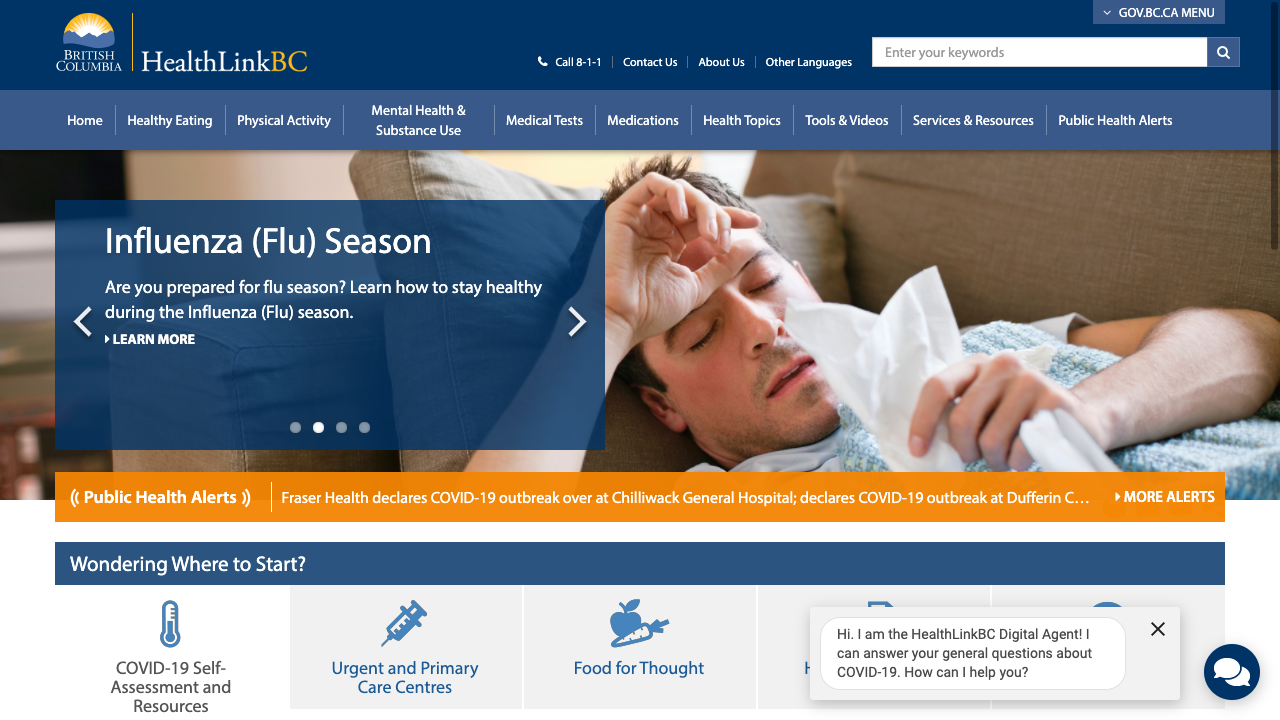

In [25]:
screenshot = Image.open(BytesIO(await pg.screenshot()))
screenshot

### Extracting information from a page

Getting the page title is easy:

In [26]:
await pg.title()

'HealthLink BC - 24/7 Health Advice You Can Trust'

Here's how to take screenshots of visible links:

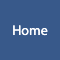

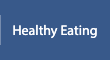

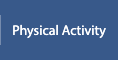

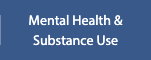

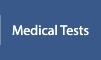

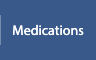

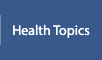

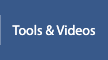

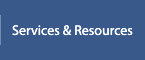

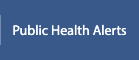

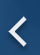

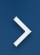

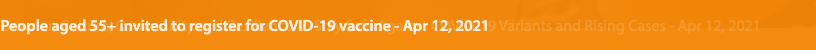

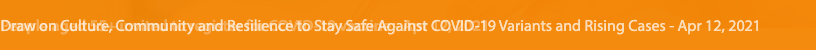

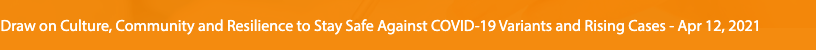

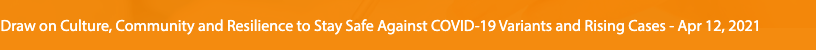

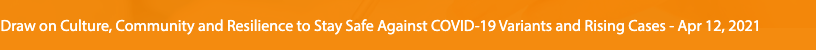

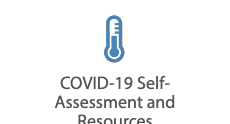

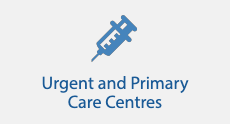

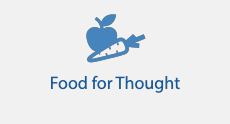

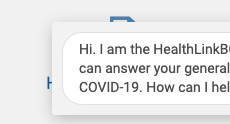

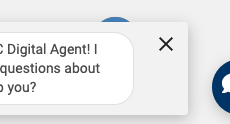

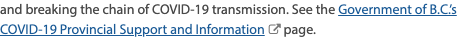

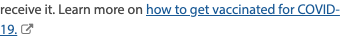

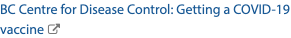

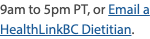

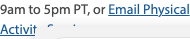

In [27]:
for link in await pg.query_selector_all("a:visible"):
    # the :visible selector uses heuristics that are not always perfectly
    # accurate so we have to handle the case where an element is not actually visible
    try:
        display(Image.open(BytesIO(await link.screenshot())))
    except playwright._impl._api_types.Error as e:
        pass

The screenshots are based on the bounding box for each element, and may be occluded by other intersecting elements that have a higher "z-index" (that is to say, by layers that are closer to the foreground). Here's the bounding box for the first visible h2 element:

In [28]:
first_h2 = await pg.query_selector("h2:visible")
await first_h2.bounding_box()

{'x': 55, 'y': -1137, 'width': 550, 'height': 64}

We can continuously screenshot that element using a background thread and an Image widget:

In [29]:
im = widgets.Image()
im # this will be a broken image until we fill in its value later

Image(value=b'')

In [30]:
async def screenshot_continuously():
    while True:
        await aio.sleep(0.5) # let's take a screenshot every half second
        im.value = await first_h2.screenshot()

screenshot_task = aio.create_task(screenshot_continuously())

The above is to show that the generated screenshot is clipped to the bounding box for an element, but the element may or may not be included in the screenshot depending on how elements are layered on the page.

If the flicker in the background gets to be too much, you can cancel the background task.

In [31]:
screenshot_task.cancel()

True

We could also use the bounding box for an element and clip to that region ourselves:

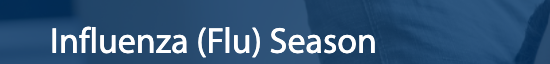

In [32]:
# first we need to make sure we're scrolled to the top of the page, however...
await pg.evaluate("""

    () => {
        document.documentElement.scrollTop = 0;
        document.documentElement.scrollLeft = 0;
    }

""")

Image.open(BytesIO(
    await pg.screenshot(
        full_page=True,
        clip=await first_h2.bounding_box())))

To extract text from the above image, we can use pytesseract's `image_to_string` function. This uses OCR to convert images into strings of characters.

In [33]:
print(pytesseract.image_to_string(Image.open(BytesIO(im.value))))

Coronavirus (COVID-19)



We don't have to process images; we can also extract information or textual content from the DOM. Here's how to get a list of on-page link URLs, for example to populate a queue for a web crawler (uses JavaScript):

In [34]:
await pg.evaluate("""

    [...document.links].map(l => l.href)

""")

['https://www.healthlinkbc.ca/#main-content',
 'https://www2.gov.bc.ca/gov/content/governments',
 'https://www2.gov.bc.ca/gov/content/health',
 'https://www2.gov.bc.ca/gov/content/life-events',
 'https://www2.gov.bc.ca/gov/content/education-training',
 'https://www2.gov.bc.ca/gov/content/transportation',
 'https://www2.gov.bc.ca/gov/content/safety',
 'https://www2.gov.bc.ca/gov/content/justice',
 'https://www2.gov.bc.ca/gov/content/taxes',
 'https://www2.gov.bc.ca/gov/content/housing-tenancy',
 'https://www2.gov.bc.ca/gov/content/sports-culture',
 'https://www2.gov.bc.ca/gov/content/environment',
 'https://www2.gov.bc.ca/gov/content/industry',
 'https://www2.gov.bc.ca/gov/content/employment-business',
 'https://www2.gov.bc.ca/gov/content/tourism-immigration',
 'https://www2.gov.bc.ca/gov/content/family-social-supports',
 'https://www.healthlinkbc.ca/',
 'https://www.healthlinkbc.ca/services-and-resources/about-8-1-1',
 'https://www.healthlinkbc.ca/contact-us',
 'https://www.healthlinkb

By using a combination of query_selector_all and get_property on the objects that are returned, we could accomplish the same thing without writing any JavaScript, although the equivalent code can be quite awkward:

In [35]:
[await (await link.get_property("href")).json_value()
    for link in await pg.query_selector_all("a")]

['https://www.healthlinkbc.ca/#main-content',
 'https://www2.gov.bc.ca/gov/content/governments',
 'https://www2.gov.bc.ca/gov/content/health',
 'https://www2.gov.bc.ca/gov/content/life-events',
 'https://www2.gov.bc.ca/gov/content/education-training',
 'https://www2.gov.bc.ca/gov/content/transportation',
 'https://www2.gov.bc.ca/gov/content/safety',
 'https://www2.gov.bc.ca/gov/content/justice',
 'https://www2.gov.bc.ca/gov/content/taxes',
 'https://www2.gov.bc.ca/gov/content/housing-tenancy',
 'https://www2.gov.bc.ca/gov/content/sports-culture',
 'https://www2.gov.bc.ca/gov/content/environment',
 'https://www2.gov.bc.ca/gov/content/industry',
 'https://www2.gov.bc.ca/gov/content/employment-business',
 'https://www2.gov.bc.ca/gov/content/tourism-immigration',
 'https://www2.gov.bc.ca/gov/content/family-social-supports',
 'https://www.healthlinkbc.ca/',
 'https://www.healthlinkbc.ca/services-and-resources/about-8-1-1',
 'https://www.healthlinkbc.ca/contact-us',
 'https://www.healthlinkb

Here's how to get elements that contain specific text content:

In [36]:
for el in await pg.query_selector_all("text=physical"):
    print(await el.text_content())

Physical Activity
Email Physical Activity Services


### You can get the HTML for a page before and after JavaScript modifies it

In [37]:
goto_response = await pg.goto("https://www.healthlinkbc.ca")

Before JavaScript modified it:

In [38]:
print((await goto_response.body())[0:200].decode())

<!DOCTYPE html>
<html lang="en">
<head>
  <meta http-equiv="X-UA-Compatible" content="IE=Edge,chrome=1">
  <meta charset="UTF-8" />
  <meta name="viewport" content="initial-scale=1">
  <meta name="goo


And now after. Note all the feature detection classes that were added:

In [39]:
print((await pg.content())[0:200])

<!DOCTYPE html><html lang="en" class="js wf-myriadpro-n9-active wf-myriadpro-i9-active wf-myriadpro-n7-active wf-myriadpro-i7-active wf-myriadpro-i4-active wf-myriadpro-n3-active wf-myriadpro-i3-activ


### Interacting with the page

The coordinate system for web pages starts at the top left of the viewport, with the x value increasing to the right, and the y value increasing as you move down the screen. This differs from plotting libraries and mathematical convention, where the y axis is flipped.

Among other things, we can move the mouse to hover over and click menu items. The line below should highlight the "Home" menu item.

In [40]:
await pg.mouse.move(100, 100)

If you know the CSS selector for the element you want to hover over, you can also use that.

In [41]:
await pg.hover("a:has-text('Home'):visible")

For a smoother effect, playwright can, with robotic precision, automatically interpolate mouse movement.

In [42]:
await pg.mouse.move(600, 100, steps=100)

To click, you can either pass a CSS selector to the `pg.click` command, or manually invoke a combination of mouse down and up events at whatever position the virtual mouse is at currently.

In [43]:
async with pg.expect_navigation():
    await pg.mouse.down()
    await pg.mouse.up()



***Fin.*** My talk stopped here (actually, even the above includes some content that was not in the talk), but your exploration of headless browsers doesn't have to! At this point, I recommend referring to [playwright's comprehensive online documentation](https://playwright.dev/python/). You may also continue reading this notebook for a few more feature demonstrations I put together after the talk.

## Recording video

Playwright records videos of all interactions if a context is opened using the record_video_dir parameter.

In [44]:
video_recording_context = await browser.new_context(
    record_video_dir=".")

In [45]:
vid_page = await video_recording_context.new_page()
vid_path = await vid_page.video.path()
await vid_page.goto("https://www.healthlinkbc.ca")
await vid_page.mouse.move(100, 100)
await vid_page.mouse.move(1000, 100, steps=200)
await aio.sleep(0.25)
async with vid_page.expect_navigation():
    await vid_page.mouse.down()
    await vid_page.mouse.up()
await aio.sleep(1)
await vid_page.close()

In [ ]:
vid = widgets.Video()
vid.from_file(str(vid_path), autoplay=False)

## Doing more than one thing at once (e.g. concurrently visiting pages)

In [46]:
top_level_links = await pg.evaluate("""

    [...document.querySelectorAll(".menu .top-level-item > a")].map(l => l.href)

""")

top_level_links

['https://www.healthlinkbc.ca/',
 'https://www.healthlinkbc.ca/healthy-eating',
 'https://www.healthlinkbc.ca/physical-activity',
 'https://www.healthlinkbc.ca/mental-health-substance-use',
 'https://www.healthlinkbc.ca/medical-tests',
 'https://www.healthlinkbc.ca/medications',
 'https://www.healthlinkbc.ca/explore-health-topics',
 'https://www.healthlinkbc.ca/tools-and-videos',
 'https://www.healthlinkbc.ca/services-and-resources',
 'https://www.healthlinkbc.ca/public-health-alerts']

In [47]:
crawling_context = await browser.new_context()

async def visit_page_in_new_tab(url, context=crawling_context):
    pg = await crawling_context.new_page()
    await pg.goto(url)
    
for url in top_level_links[1:5]:
    aio.create_task(visit_page_in_new_tab(url))

## Responding to page events

First, let's set up an output sink...

In [48]:
event_output_sink = widgets.Output()
event_output_sink

Output()

Now we can monitor pages for events such as JavaScript errors or console messages.

In [49]:
async def show_error(e):
    event_output_sink.append_stdout(
        "\n" + e.stack)

pg.on("pageerror", show_error)

In [50]:
async def show_console_message(e):
    event_output_sink.append_stdout("\n" + e.text)
    
pg.on("console", show_console_message)

In [51]:
await pg.add_script_tag(
    content="""
    
        console.log("hello, world!");
        throw new Error("error, world.");
        
    """)

<JSHandle preview=JSHandle@node>

In [52]:
pg._impl_obj._events["console"].clear()
pg._impl_obj._events["pageerror"].clear()

## Intercepting requests

Playwright can intercept HTTP requests and cancel them, continue them, or return a custom response. Cancelling requests could be used for many things, such as simulating poor network conditions or restricting requests to one specific domain name; the latter may be used to fence off a web crawling job. By using the Chrome DevTools Protocol directly it is also possible to dynamically modify responses, but that is out of scope for this notebook.

In [53]:
import random

async def randomly_do_nothing(request):
    if random.choice([True, False]):
        await request.abort()
    else:
        await request.continue_()

await pg.route("**", randomly_do_nothing)

In [55]:
await pg.goto("https://www.healthlinkbc.ca") # with the above route in place, this will throw an error 50% of the time

<Response url='https://www.healthlinkbc.ca/' request=<Request url='https://www.healthlinkbc.ca/' method='GET'>>

In Jupyter notebooks, the unroute function will come in handy:

In [56]:
# restore network connectivity
await pg.unroute("**")

## Why the emphasis on screenshots and manual mouse control? Aren't there better ways to programatically click things?

There are API calls that will be more convenent than the above if all you want to do, for example, is click a button that includes some fixed string of text. I took things from a less conventional, more visually oriented angle, however, and that wasn't just to make the talk more engaging, with pictures deployed for prop value; what I was leading up to is that headless browsers meet all the requirements needed to function as an "[AI gym](https://gym.openai.com/)", i.e. as an environment in which to train agents using deep reinforcement learning algorithms or other techniques. Namely, headless browsers provide:

 - a set of actions; and
 - a way of observing the effect of these actions, such as by taking screenshots or extracting other information from the running browser instance
 
With these two things, and a heuristic for rewards, which you could write either in python or JavaScript, you have everything you need to plug in the <acronym title="Reinforcement Learning">RL</acronym> architecture of your choosing, and have an agent that could, perhaps, undertake some tasks by following an example instead of explicitly coded routines. 

I hope this has provided enough food for thought, and given you ideas for how to get started with the exciting world of headless browsers!
 